<bound method NDFrame.head of      Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50 

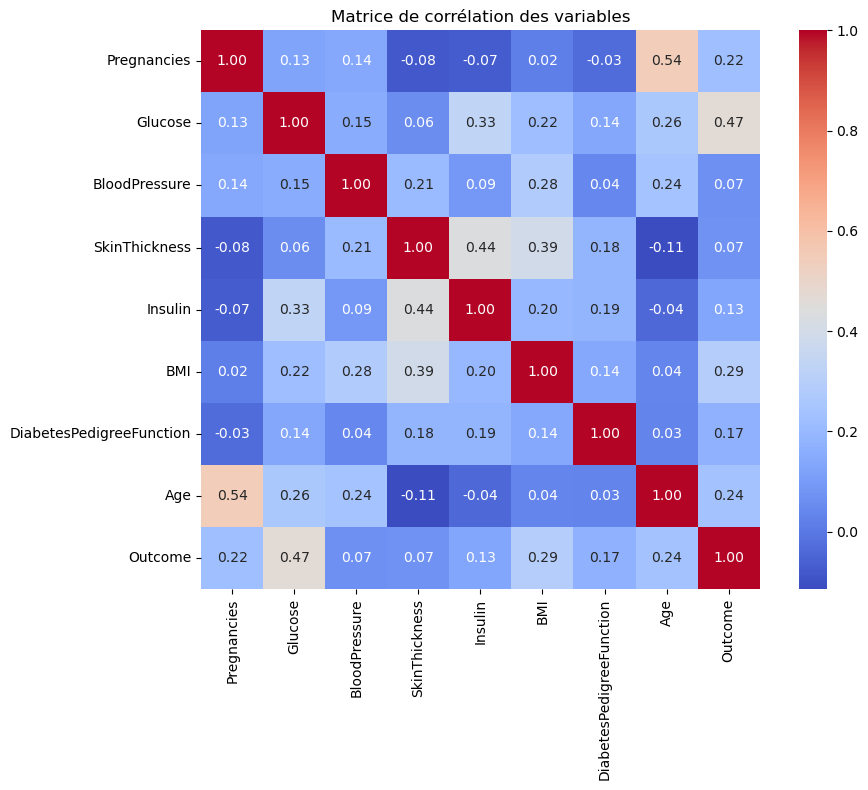

In [2]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement des données
data = pd.read_csv('diabetes.csv')
print(data.head)

# Affichage de la matrice de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Matrice de corrélation des variables")
plt.tight_layout()
plt.show()



Nous avons commencé par charger le dataset que nous avons sélectionné, puis nous avons affiché son en-tête à l’aide de la fonction head() afin d’avoir un aperçu général des données. Cela nous a permis d’identifier les différentes variables disponibles ainsi que leur nature.
Ensuite, nous avons réalisé une analyse exploratoire, notamment en traçant la matrice de corrélation, afin d’examiner les relations linéaires entre les différentes variables, et en particulier avec la variable cible Outcome (diagnostic du diabète).
Nous avons constaté que certaines variables comme Glucose (≈ 0.47), BMI (≈ 0.29), Age (≈ 0.24) et Pregnancies (≈ 0.22) sont modérément corrélées à la variable cible.
Malgré cela, aucune variable ne présentait une corrélation suffisamment faible pour être considérée comme inutile. Nous avons donc décidé de conserver l’ensemble des caractéristiques car chacune apporte une information pertinente pour la prédiction, même si leur influence varie.

In [ ]:

# Séparation des données en variables explicatives (X) et variable cible (y)
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Séparation des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Prétraitement des données (imputation et normalisation)
numeric_features = X.columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # Imputation des valeurs manquantes
    ('scaler', StandardScaler())  # Normalisation des données
])



Dans cette partie, on commence par séparer les données en variables explicatives X (toutes les colonnes sauf la cible) et la variable cible y (la colonne 'Outcome' qui indique si la personne est diabétique ou non). Cette séparation est essentielle pour entraîner un modèle supervisé.

Ensuite, les données sont divisées en deux ensembles : un ensemble d'entraînement (X_train, y_train) et un ensemble de test (X_test, y_test). On utilise ici une séparation de 70 % des données pour l’entraînement et 30 % pour le test, avec un random_state fixé pour garantir la reproductibilité des résultats.

Puis, on prépare le prétraitement des variables numériques via un pipeline numeric_transformer. Ce pipeline applique deux étapes successives : d'abord, il remplace les valeurs manquantes par la médiane de la colonne grâce à un SimpleImputer, puis il normalise les données avec un StandardScaler afin de centrer et réduire les variables numériques. Ce prétraitement est important pour améliorer la performance et la stabilité des modèles d’apprentissage.

In [ ]:
# Création du préprocesseur
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Création du pipeline avec Naive Bayes
pipe_nb = Pipeline([
    ('preprocessing', preprocessor),
    ('nb', GaussianNB())  # Modèle Naive Bayes
])

# GridSearchCV pour le tuning des hyperparamètres
param_grid = {
    'nb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

grid_search = GridSearchCV(pipe_nb, param_grid, cv=5, scoring='accuracy', n_jobs=-1)


Dans cette étape, on crée un préprocesseur avec ColumnTransformer qui applique le pipeline de transformation défini précédemment (numeric_transformer) uniquement sur les variables numériques. Cela permet de préparer automatiquement les données avant l'entraînement du modèle.

Ensuite, on construit un pipeline complet (pipe_nb) qui intègre ce prétraitement suivi de l’algorithme de classification Naive Bayes (GaussianNB). L’utilisation d’un pipeline garantit que les mêmes transformations sont appliquées de manière cohérente à chaque étape, que ce soit à l’entraînement ou lors des prédictions.

Pour optimiser les performances du modèle, on utilise GridSearchCV, une méthode de recherche exhaustive des meilleurs hyperparamètres via une validation croisée à 5 plis (cv=5). Ici, on teste différentes valeurs pour le paramètre var_smoothing de Naive Bayes, qui contrôle la stabilité numérique en ajoutant une petite valeur au calcul des variances. Cette étape vise à trouver le réglage qui maximise la précision (accuracy) du modèle. Le calcul est parallélisé (n_jobs=-1) pour accélérer la recherche.

In [ ]:

# Entraînement du modèle
grid_search.fit(X_train, y_train)

# Meilleurs paramètres
best_model = grid_search.best_estimator_
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Prédictions sur les données de test
y_pred_nb = best_model.predict(X_test)

# Évaluation du modèle
acc_nb = accuracy_score(y_test, y_pred_nb)
print(f'\nPrécision du modèle Naive Bayes sur les données de test : {acc_nb:.4f}')

# Classification Report
print("\nClassification Report :")
print(classification_report(y_test, y_pred_nb))

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_nb)
print("\nMatrice de confusion :")
print(conf_matrix)

# Affichage sous forme de heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Diabétique', 'Diabétique'], yticklabels=['Non Diabétique', 'Diabétique'])
plt.title('Matrice de Confusion Naive Bayes')
plt.ylabel('Valeurs réelles')
plt.xlabel('Prédictions')
plt.show()

# Validation croisée sur l'ensemble d'entraînement
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nPrécision moyenne en validation croisée : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Résumé automatique
print("\nRésumé :")
print(f"Précision sur les données de test : {acc_nb:.4f}")
print(f"Matrice de confusion :\n{conf_matrix}")
print(f"Classification Report :\n{classification_report(y_test, y_pred_nb)}")


Le modèle Naive Bayes est entraîné sur l’ensemble d’entraînement (X_train, y_train) en utilisant la recherche par grille (GridSearchCV) pour optimiser le paramètre var_smoothing. Une fois l’entraînement terminé, on récupère le meilleur modèle et ses hyperparamètres optimaux. On utilise ensuite ce modèle pour faire des prédictions sur l’ensemble de test (X_test).

La performance est évaluée par la précision (accuracy_score), qui indique la proportion de prédictions correctes. On affiche également un rapport de classification détaillé qui donne la précision, le rappel, le F1-score pour chaque classe (diabétique / non diabétique), ce qui permet d’évaluer la qualité du modèle au-delà de la simple précision.

La matrice de confusion est générée et affichée sous forme de heatmap, ce qui permet de visualiser le nombre de vrais positifs, vrais négatifs, faux positifs et faux négatifs, donnant ainsi une meilleure idée des erreurs de classification du modèle.

Enfin, une validation croisée à 5 plis est réalisée sur l’ensemble d’entraînement pour estimer la stabilité et la robustesse du modèle, donnant une moyenne et un écart-type de la précision sur les différents sous-ensembles de données.

Un résumé final est imprimé, regroupant la précision sur le test, la matrice de confusion et le rapport de classification, afin de synthétiser les résultats de manière claire et concise.

## NOTES ##

Le meilleur hyperparamètre trouvé pour le modèle Naive Bayes est var_smoothing égal à 1e-09, ce qui correspond à une régularisation très faible, adaptée à des données relativement propres et peu bruitées. La précision obtenue sur les données de test est de 74,46 %, indiquant que le modèle classe correctement près des trois quarts des exemples. Cela reflète une performance raisonnable, mais avec une marge d’amélioration.

Le rapport de classification détaille les performances par classe : pour la classe 0 (non diabétique), la précision est élevée à 82 %, le rappel est de 79 % et le F1-score atteint 0,80, montrant que le modèle détecte bien cette classe. En revanche, pour la classe 1 (diabétique), la précision chute à 62 %, le rappel est à 66 % et le F1-score à 0,64, ce qui souligne une difficulté du modèle à bien identifier les diabétiques. La précision moyenne macro (moyenne simple) est de 72 %, tandis que la précision pondérée (tenant compte de la proportion des classes) est légèrement plus élevée à 75 %, reflétant un léger déséquilibre dans les classes.

La matrice de confusion confirme ces observations : le modèle identifie correctement 119 non diabétiques (vrais négatifs) mais classe à tort 32 non diabétiques comme diabétiques (faux positifs). Du côté des diabétiques, 53 sont correctement détectés (vrais positifs) tandis que 27 sont manqués (faux négatifs). Ces résultats montrent que le modèle est plus performant pour la classe majoritaire (non diabétiques) que pour la minoritaire (diabétiques).

Enfin, la validation croisée avec une précision moyenne de 75,42 % et un écart-type faible (2,99 %) indique que le modèle est stable et généralise bien sur différentes partitions des données.

## CONCLUSION ## 

Le modèle Naive Bayes présente une bonne capacité à identifier les non diabétiques avec des scores solides, et sa stabilité est confirmée par la validation croisée. Toutefois, la détection des diabétiques reste moins satisfaisante, ce qui peut s’expliquer par un déséquilibre des classes dans le jeu de données. Pour améliorer la performance sur la classe diabétique, il serait pertinent d’envisager des techniques de rééchantillonnage (comme SMOTE), ou d’utiliser des pondérations de classes. Par ailleurs, tester d’autres modèles (Random Forest, SVM, régression logistique) pourrait aussi permettre d’obtenir de meilleurs résultats, en particulier pour la classe minoritaire. En somme, Naive Bayes constitue une bonne base, mais nécessite des ajustements pour mieux gérer le déséquilibre des classes et améliorer la détection des cas diabétiques.